In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from google.colab import files

In [2]:
data = files.upload()

Saving Data RSL.csv to Data RSL.csv


In [3]:
df = pd.read_csv('Data RSL.csv')

**Dropping Unneccessary Columns**

In [4]:
cols = ['GOV', 'TAX', 'YEA','Unit Code','Unit','PowerCode Code','PowerCode','Reference Period Code','Reference Period','Flag Codes','Flags']
df = df.drop(cols, axis=1)

In [5]:
df.head(2)

,Level of government,Revenue category,Year,Value
0,Federal or Central government,Total tax and non-tax revenue,2004,4001.294
1,Federal or Central government,Total tax and non-tax revenue,2005,4437.224


**TASK 1**


**MISSING VALUES**

In [6]:
def handle_missing_values(df):
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].dtype == np.float64:
                df[col] = df[col].fillna(df[col].mean())
            else:
                df[col] = df[col].fillna(df[col].mode().iloc[0])
    return df

df = handle_missing_values(df.copy())

**DETERMINING AN OUTLIERS USING THE 1.5 IQR RULE**

In [7]:
def identify_outliers(df):
    for col in df.select_dtypes(include=[np.number]):
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        print(f"Outliers in {col}: {outliers.shape[0]}")
    return df

df = identify_outliers(df.copy())

Outliers in Year: 0
Outliers in Value: 198


 **TASK 2**

 **EXPLORATORY DATA ANALYSIS**

In [8]:
df.describe()

,Year,Value
count,1728.000000,1728.000000
mean,2012.500000,1650.746302
std,5.189629,2940.416337
min,2004.000000,-866.652000
25%,2008.000000,0.000000
50%,2012.500000,464.790000
75%,2017.000000,1857.219000
max,2021.000000,19131.238000


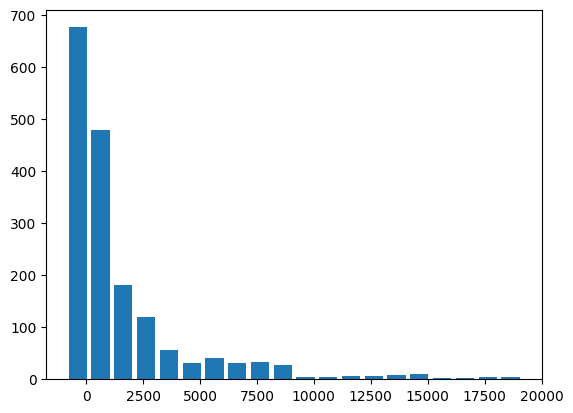

In [9]:
plt.hist(df.Value,bins=20, rwidth=0.8)
plt.show()

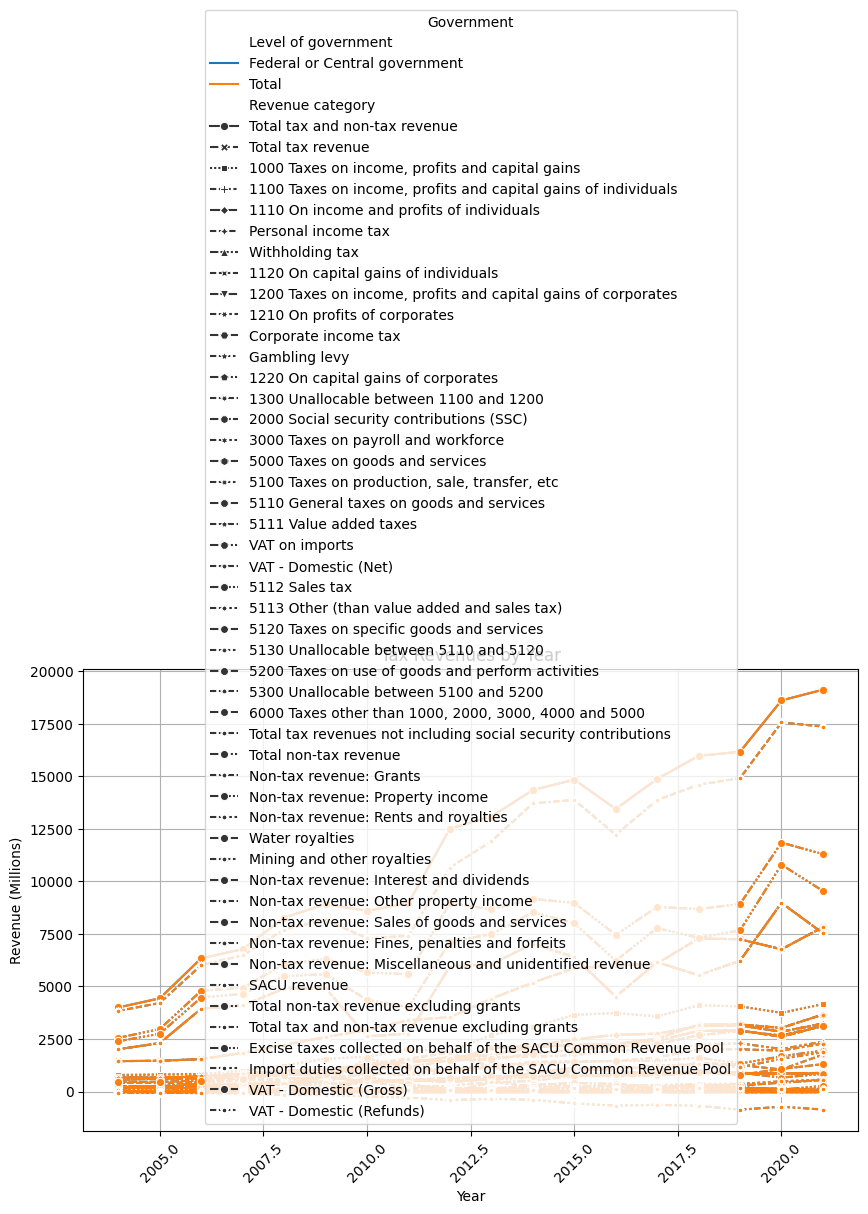

In [10]:
# Distribution of tax revenues by year
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='Year', y='Value', hue='Level of government', style='Revenue category', markers=True)
plt.title('Tax Revenues by Year')
plt.xlabel('Year')
plt.ylabel('Revenue (Millions)')
plt.xticks(rotation=45)
plt.legend(title='Government')
plt.grid(True)
plt.show()

In [53]:
# Encoding categorical features
label_encoder_gov = LabelEncoder()
df['Level of government'] = label_encoder_gov.fit_transform(df['Level of government'])

label_encoder_rev = LabelEncoder()
df['Revenue category'] = label_encoder_rev.fit_transform(df['Revenue category'])

one_hot_encoder = OneHotEncoder(sparse=False)
encoded_features = one_hot_encoder.fit_transform(df[['Level of government', 'Revenue category']])

# Save encoders
with open('level_of_government_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder_gov, file)

with open('revenue_category_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder_rev, file)

with open('one_hot_encoder.pkl', 'wb') as file:
    pickle.dump(one_hot_encoder, file)

# Manually create feature names
encoded_cols = []
for i, category in enumerate(one_hot_encoder.categories_):
    encoded_cols.extend([f'{df.columns[i]}_{val}' for val in category])

df_encoded = pd.concat([df.drop(columns=['Level of government', 'Revenue category']),
                        pd.DataFrame(encoded_features, columns=encoded_cols)], axis=1)

# Scaling numerical features
scaler = StandardScaler()
df_encoded[['Year']] = scaler.fit_transform(df_encoded[['Year']])

# Save scaler
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


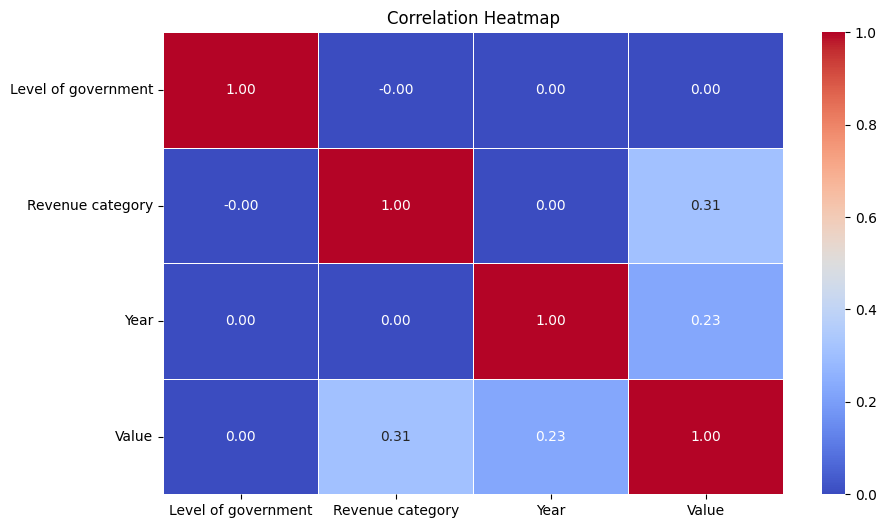

In [54]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

 **TASK 3**

 **FEATURE ENGINEERING**

In [55]:
# Convert 'Year' and 'Value' to numeric
df['Year'] = pd.to_numeric(df['Year'])
df['Value'] = pd.to_numeric(df['Value'])

In [56]:
## Encoding categorical features
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(df[['Level of government', 'Revenue category']])
encoded_cols = encoder.get_feature_names_out(['Level of government', 'Revenue category'])
df_encoded = pd.concat([df.drop(columns=['Level of government', 'Revenue category']), pd.DataFrame(encoded_features, columns=encoded_cols)], axis=1)

# Save OneHotEncoder
with open('one_hot_encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)

# Scaling numerical features
scaler = StandardScaler()
scaled_values = scaler.fit_transform(df_encoded[['Year', 'Value']])
scaled_cols = ['Year_scaled', 'Value_scaled']
df_encoded[scaled_cols] = pd.DataFrame(scaled_values, columns=scaled_cols)

# Save StandardScaler
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

#print(df_encoded.head(2))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


**TASK 4**

**MODEL TRAINING USING LINEARREGRESSION**

In [57]:
# Preprocess the dataset
#def preprocess_data(data):
    # One-hot encode categorical features
#    ct = ColumnTransformer(
#        [('one_hot_encoder', OneHotEncoder(), [0, 1])],
#        remainder='passthrough'
#    )
#    data_encoded = ct.fit_transform(data)
#    return data_encoded

In [58]:
# Preprocess the dataset
X = df[['Level of government', 'Revenue category', 'Year']]
y = df['Value']
X_encoded = preprocess_data(X)

In [59]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
# Preprocess the training set
X_train_encoded = preprocess_data(X_train)

In [61]:
# Train the model
model = LinearRegression()
model.fit(X_encoded, y)

LinearRegression()

In [62]:
# Preprocess the testing set
X_test_encoded = preprocess_data(X_test)

In [63]:
# Evaluate the model
test_predictions = model.predict(X_test_encoded)

mae = mean_absolute_error(y_test, test_predictions)
r2 = r2_score(y_test, test_predictions)

print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Absolute Error: 542.9035143341262
R-squared: 0.917931852530817


**TASK 5**

**Model tuning using Grid Search Cross-Validation**



In [64]:
# Define the pipeline with preprocessing and model
pipeline = Pipeline([
    ('preprocessing', ColumnTransformer(
        [('one_hot_encoder', OneHotEncoder(), [0, 1])],
        remainder='passthrough'
    )),
    ('scaling', StandardScaler(with_mean=False)),
    ('regression', LinearRegression())
])

In [65]:
# Define hyperparameters to tune
param_grid = {
    'regression__fit_intercept': [True, False]
}

In [66]:
# Grid Search Cross-Validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 480, in predict
    Xt = transform.transform(Xt)
  File "/usr/local/lib/python3.10/dist-packages/sklea

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one_hot_encoder',
                                                                         OneHotEncoder(),
                                                                         [0,
                                                                          1])])),
                                       ('scaling',
                                        StandardScaler(with_mean=False)),
                                       ('regression', LinearRegression())]),
             param_grid={'regression__fit_intercept': [True, False]},
             scoring='neg_mean_absolute_error')

In [67]:
# Best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

Best Hyperparameters: {'regression__fit_intercept': True}


In [68]:
# Predictions using the best model
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

In [69]:
# Evaluate the tuned model
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
print("Tuned Model Mean Absolute Error:", mae_tuned)

Tuned Model Mean Absolute Error: 542.9035143098922


In [77]:
#from google.colab import drive
#drive.mount('my-drive')

In [78]:
#cd /content/my-drive/MyDrive/SavedModels

In [80]:
with open('ai_model.pkl','wb')as file:
  pickle.dump(model,file)

OSError: [Errno 107] Transport endpoint is not connected: 'ai_model.pkl'